In [1]:
import warnings as _wrn
_wrn.filterwarnings('always')

In [2]:
import sys as _sys
import itertools as _itr

import numpy as _nmp
import numpy.random as _rnd
import matplotlib.pyplot as _plt
import pandas as _pnd

%load_ext autoreload
%autoreload 2
%matplotlib inline

_plt.style.use('ggplot')

In [3]:
import eQTLseq as _assoc

In [4]:
# load and align data
GENO = _pnd.read_table('/home/dimitris/Data/Geuvadis/VCF/genotypes.TF.common.HIGH.txt', index_col=0, header=None)
# COUNTS = _pnd.read_table('/home/dimitris/Data/Geuvadis/counts/counts_miRNAs.txt', index_col=0)
COUNTS = (_pnd.read_table('/home/dimitris/Data/Geuvadis/counts/counts_genes.txt', index_col=[0,1,2])
          .xs('protein_coding', level='BIOTYPE', drop_level=False))

samples = GENO.index & COUNTS.columns

COUNTS = COUNTS[samples]
GENO = GENO.loc[samples]

data = {
    'G': GENO.values,
    'Z': COUNTS.values
}

# filter
data['G'] = data['G'][:, data['G'].sum(0) > 0]     # remove mono-morphic loci
row_sums = data['Z'].sum(1)
data['Z'] = data['Z'][row_sums > _nmp.percentile(row_sums, 60), :]
# data['Z'] = data['Z'][row_sums > 0, :]

data['G'].shape, data['Z'].shape

((462, 21), (7852, 462))

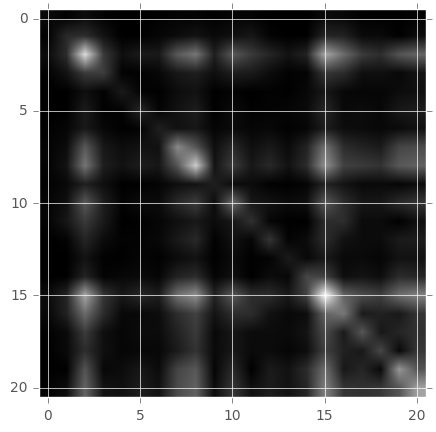

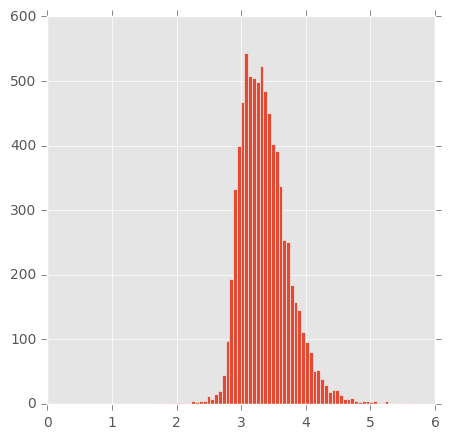

In [5]:
_plt.figure(figsize=(5,5));
_plt.imshow(data['G'].T.dot(data['G']), cmap=_plt.cm.Greys_r);

_plt.figure(figsize=(5,5));
_plt.hist(_nmp.log10(data['Z'][:, 0] + 1), bins=100);

In [6]:
_rnd.seed(0)
Z = data['Z'] / _assoc.calculate_norm_factors(data['Z'])
# Z = _assoc.transform_data(Z, kind='blom')
res = _assoc.run(Z, data['G'], n_iters = 2000, mdl='Binomial', scale=True, n_threads=4)

100%|██████████| 2000/2000 [42:30<00:00,  1.24s/it]


array([[   0,    1],
       [   2,   11],
       [  15,   11],
       ..., 
       [7837,   11],
       [7842,   16],
       [7850,    1]])

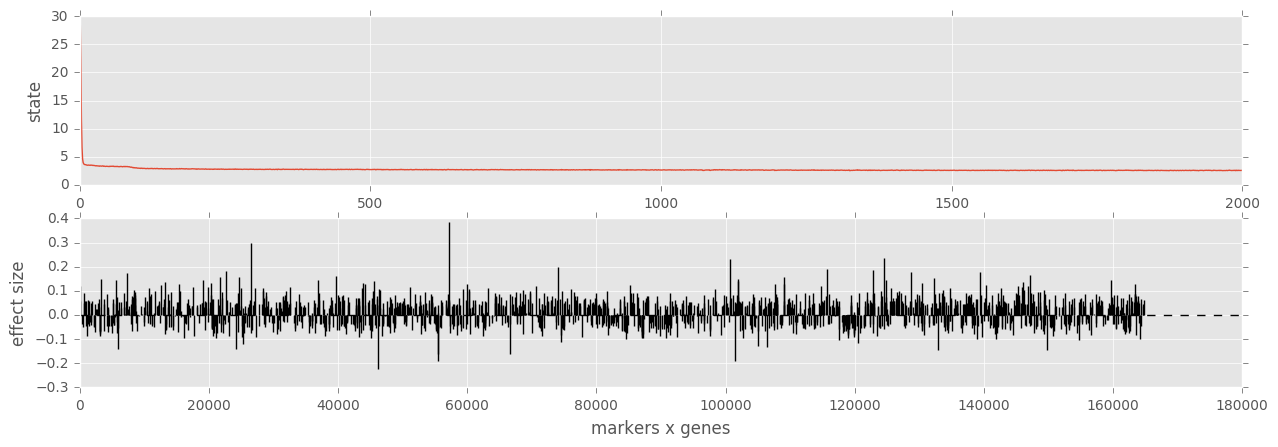

In [7]:
_plt.figure(figsize = (15,10));

_plt.subplot(4,1,1); _plt.plot(res['state']); _plt.xlabel('iteration'); _plt.ylabel('state')

_plt.subplot(4,1,2); _plt.vlines(range(res['beta'].size), 0, res['beta'].ravel()); _plt.xlabel('markers x genes'); _plt.ylabel('effect size')
_plt.axhline(linestyle='--', color='k');

_nmp.transpose((_nmp.abs(res['beta']) > 1e-6).nonzero())

In [8]:
_nmp.transpose((_nmp.abs(res['beta']) > 1e-6).nonzero()).shape

(1796, 2)

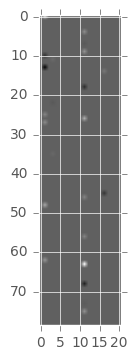

In [12]:
_plt.imshow(res['beta'][::100, :], cmap=_plt.cm.gray)

In [131]:
res_nb = res